# Detección de cambios en la cobertura terrestre de los pastizales

- **Nombre:**  Daniela Rayo Álvarez
- **Programa:** Doctorado en Ciencias Agrarias
- **Facultad:**  Facultad de Ciencias Agrarias

# Introducción

Los pastizales áridos y semiáridos cubren el 41% del planeta y son clave para millones de personas y el pastoreo global, pero enfrentan cambios acelerados por el clima, la agricultura, la urbanización y la gestión. Las bases de datos tradicionales  **(MODIS, GlobCover, WorldCover)** tienen baja precisión en estas zonas y solo detectan cambios cuando ya son evidentes. Nuevas herramientas como **LandTrendr** permiten analizar series temporales de imágenes satelitales y detectar cambios sutiles en la vegetación, generando clasificaciones basadas en la trayectoria de los píxeles a lo largo del tiempo. Esto ofrece información más precisa sobre la condición y resiliencia de los ecosistemas frente al cambio climático y la actividad humana.

# Objetivos

* Identificar y explicar las limitaciones de los datos tradicionales de cobertura terrestre en pastizales áridos.
* Aplicar algoritmos de segmentación temporal a series de datos sobre la productividad de la vegetación.
* Clasificar píxeles según las similitudes en sus trayectorias temporales.
* Extraer y visualizar las nuevas clases basadas en trayectorias.
* Comparar estas clases con la información proveniente de los productos tradicionales de cobertura terrestre.

# PASO 1: Inicializar Earth Engine y definir el AOI

## 1. API de Earth Engine

### 1.1. Instalación

Antes de iniciar el proyecto, se deben instalar dos paquetes esenciales para el procesamiento y análisis de datos geoespaciales:

- **`earthengine-api`**: Permite el acceso programático a Google Earth Engine para consultar, procesar y analizar datos satelitales a gran escala.
- **`geemap`**: Extiende las funcionalidades de Earth Engine, facilitando la visualización interactiva y la manipulación de datos dentro de entornos como Jupyter Notebook o Google Colab.

In [20]:
!pip install earthengine-api
!pip install geemap

### 1.2. Autenticación de Earth Engine 

In [21]:
import ee
ee.Authenticate()

True

### 1.3. Inicializa Earth Engine

In [22]:
ee.Initialize()

# PASO 2: Visualizar productos MODIS y WorldCover

## 2.1 Librerías 

| Librería                                                                                  | Descripción                                               |
|-------------------------------------------------------------------------------------------|--------------------------------------------------------------------|
| [Matplotlib Pyplot](https://matplotlib.org/stable/api/pyplot_summary.html)                 | Creación de gráficos, diagramas y visualizaciones 2D de forma sencilla e interactiva. |
| [Matplotlib Colors](https://matplotlib.org/2.0.1/api/colors_api.html) | Herramientas para definir, manipular y personalizar mapas de color y escalas en visualizaciones gráficas. |
| [ColorbarBase](https://matplotlib.org/stable/api/colorbar_api.html)                       | Clase para crear barras de color personalizadas que representan escalas de valores en los gráficos. |
| [NumPy](https://numpy.org/doc/stable/)                                                    | Biblioteca para cálculos numéricos de alto rendimiento, manejo de matrices y operaciones matemáticas avanzadas. |
| [Requests](https://requests.readthedocs.io/en/latest/)                                    | Permite realizar solicitudes HTTP de forma simple para descargar datos o interactuar con APIs web. |
| [Pillow (PIL)](https://pillow.readthedocs.io/en/stable/)                                 | Biblioteca para abrir, procesar y manipular archivos de imagen en diversos formatos dentro de aplicaciones Python. |
| [IO - Python Docs](https://docs.python.org/3/library/io.html)                            | Módulo estándar para manejar flujos de datos en memoria, ideal para cargar y procesar datos binarios como imágenes o archivos descargados. |
| [Pandas](https://pandas.pydata.org/docs/)                                                 | Herramienta clave para el análisis, manipulación y estructuración de datos en tablas (DataFrames) de gran tamaño. |
| [Matplotlib Ticker](https://matplotlib.org/stable/api/ticker_api.html)                   | Proporciona control detallado sobre los formatos y ubicaciones de las etiquetas en los ejes de los gráficos. |


In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase  
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import pandas as pd
import matplotlib.ticker as mticker
from matplotlib.colors import Normalize

## 2.2. Función de visualización

Descarga y visualiza imágenes de Google Earth Engine (GEE) usando `matplotlib`.

**Parámetros**

- **region**: `ee.Geometry` o `ee.FeatureCollection` (área de interés).
- **titulo**: Título del gráfico.
- **min_val**, **max_val**: Escala de color (mínimo y máximo).
- **palette**: Lista de colores (opcional).
- **dimensiones**: Tamaño de la imagen (píxeles).
- **formato**: `'png'` o `'jpg'`.
- **ax**: Eje de `matplotlib` (opcional).
- **barra_color**: Mostrar barra de color (bool, opcional).

**Proceso**

1. **Conversión de región**  
   Si es `FeatureCollection`, se transforma en `Geometry`.

2. **Generación de URL de miniatura**  
   Obtiene URL de vista previa con `getThumbURL`.

3. **Descarga y apertura de imagen**  
   - Descarga con `requests.get(url)`.  
   - Se abre la imagen con `Image.open()`.

4. **Visualización con Matplotlib**  
   - Se crea figura y eje (`plt.subplots`).  
   - Muestra la imagen (`ax.imshow`).  
   - Oculta ejes y añade título.

5. **Barra de color (opcional)**  
   - Crea paleta personalizada (`ListedColormap`).  
   - Ajusta escala de valores (`Normalize`).

In [24]:
def mostrar_imagen_ee(
    imagen,
    region,
    titulo="Imagen EE",
    min_val=0,
    max_val=255,
    palette=None,
    dimensiones=512,
    formato="png",
    ax=None,
    barra_color=True  # Controla si quieres barra de color, útil para casos individuales
):
    """
    Descarga y muestra una imagen de Earth Engine en matplotlib, con escala de colores.
    Si no se puede descargar una imagen válida, omite el gráfico.
    """

    if isinstance(region, ee.FeatureCollection):
        region = region.geometry()

    url = imagen.getThumbURL({
        'region': region.bounds(),
        'dimensions': dimensiones,
        'format': formato,
        'min': min_val,
        'max': max_val,
        'palette': palette or ['000000', 'FFFFFF']
    })

    response = requests.get(url)

    # Validación: si el contenido recibido no es imagen válida
    if len(response.content) < 1000:
        print(f"No se obtuvo imagen válida desde Earth Engine, se omite: {titulo}")
        return

    img = Image.open(BytesIO(response.content))

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img)
        ax.set_title(titulo, fontsize=14)
        ax.axis("off")

        if palette and barra_color:
            cmap = mcolors.ListedColormap([f"#{c}" for c in palette])
            norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
            cax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
            ColorbarBase(ax=cax, cmap=cmap, norm=norm, orientation='vertical')
            cax.set_ylabel('Valores (escala relativa)', fontsize=10)

        fig.subplots_adjust(left=0.05, right=0.8, top=0.90, bottom=0.05)
        plt.show()

    else:
        ax.imshow(img)
        ax.set_title(titulo, fontsize=12)
        ax.axis("off")


## 2.3. Función para imprimir bandas de una colección

**¿Por qué se llama `coleccion_id`?**

- El parámetro `coleccion_id` es el **identificador** de una colección de imágenes en Earth Engine.
- Es una cadena de texto que representa la ruta o nombre único del dataset.
**¿Qué hace cada componente?**

| **Elemento**               | **Descripción Técnica**                                                                              |
|----------------------------|-----------------------------------------------------------------------------------------------------|
| `ee.ImageCollection()`      | Crea un objeto de colección de imágenes de Earth Engine a partir del `coleccion_id` proporcionado. Contiene múltiples imágenes satelitales u observaciones temporales. |
| `.bandNames()`              | Obtiene la lista de nombres de las bandas (variables o capas) contenidas en una imagen. Es un objeto de tipo **ee.List**, no un dato inmediato para Python. |
| `.getInfo()`                | Solicita la descarga de los datos al entorno local (cliente). Convierte el resultado en una lista de Python que se puede imprimir o manipular. Solo debe usarse con datos pequeños. |

In [ ]:
def listar_bandas(coleccion_id):
    img = ee.ImageCollection(coleccion_id).first()
    bandas = img.bandNames()
    print(f'Bandas de {coleccion_id}:')
    print(bandas.getInfo())
    print('-' * 50)

## 2.3. Área de Interés (AOI) desde los Assets de Google Earth Engine como FeatureCollection

In [30]:
aoi = ee.FeatureCollection("projects/ee-drayoa/assets/Rozo")

## 2.3. MODIS Land Cover

**MODIS MCD12Q1 vs MOD13Q1**

**Características**

| **Atributo**             | **MCD12Q1 - Cobertura de Suelo**                        | **MOD13Q1 - Vegetación (NDVI/EVI)**                  |
|--------------------------|---------------------------------------------------------|------------------------------------------------------|
| Producto                 | Clasificación global de cobertura de suelo              | Índices de vegetación NDVI y EVI                     |
| Resolución Espacial      | 500 m a 1 km (según versión)                           | 250 m                                                |
| Resolución Temporal      | Anual                                                   | Cada 16 días                                         |
| Periodo Disponible       | Desde 2001 hasta la actualidad                         | Desde 2000 hasta la actualidad                      |
| Bandas/Variables         | `LC_Type1` a `LC_Type5` (Categorías de uso/cobertura)  | NDVI, EVI, Ángulos de visión, Calidad (QA)          |
| Cobertura Geográfica     | Global                                                  | Global                                               |
| Detección de Cambio      | Cambios anuales en el uso/cobertura del suelo           | Cambios estacionales o intra-anuales en la vegetación |

**Aplicaciones**

- **MCD12Q1**  
  Mapas de uso de suelo, cambio de cobertura, modelos ecológicos, análisis de flujos de carbono, dinámica de vegetación a gran escala.

- **MOD13Q1**  
  Monitoreo de vegetación, productividad primaria, estudios fenológicos, detección de sequías, dinámica estacional.

**Clasificación IGBP (`LC_Type1` - 17 Categorías)**

| **Banda**      | **Esquema**                          | **Descripción**                                                   |
|----------------|--------------------------------------|-------------------------------------------------------------------|
| `LC_Type1`     | IGBP (International Geosphere-Biosphere Programme) | Clasificación en 17 categorías globales, estándar más utilizado. |
| `LC_Type2`     | UMD (University of Maryland)         | Clasificación basada en tipos de vegetación y suelo, orientada a análisis regionales. |
| `LC_Type3`     | LAI/FPAR Biomes                     | Clasificación según biomas relevantes para índices de vegetación y producción primaria. |
| `LC_Type4`     | BGC (Biogeochemical Cycles)         | Categorías adaptadas a estudios de flujos de carbono y ciclos biogeoquímicos. |
| `LC_Type5`     | PFT (Plant Functional Types)        | Tipología funcional de la vegetación, útil para modelos dinámicos de vegetación. |

| **Clase** | **Color Hex** | **Descripción**                                          |
|------------|----------------|---------------------------------------------------------|
| 0          | `#05450a`      | Sin asignar                                             |
| 1          | `#086a10`      | Bosque de hoja perenne de coníferas                     |
| 2          | `#54a708`      | Bosque de hoja perenne de latifoliadas                  |
| 3          | `#78d203`      | Bosque de hoja caduca de coníferas                      |
| 4          | `#009900`      | Bosque de hoja caduca de latifoliadas                   |
| 5          | `#c6b044`      | Bosque mixto                                            |
| 6          | `#dcd159`      | Matorral cerrado                                        |
| 7          | `#dade48`      | Matorral abierto (leñosas 1-2 m, 10-60% cobertura)     |
| 8          | `#fbff13`      | Sabanas leñosas                                         |
| 9          | `#b6ff05`      | Sabanas                                                 |
| 10         | `#27ff87`      | Pastizales (dominados por herbáceas <2 m)               |
| 11         | `#c24f44`      | Humedales permanentes                                   |
| 12         | `#a5a5a5`      | Tierras cultivadas (≥ 60% área cultivada)               |
| 13         | `#ff6d4c`      | Áreas urbanas o construidas                             |
| 14         | `#69fff8`      | Mosaico agrícola / vegetación natural                   |
| 15         | `#f9ffa4`      | Nieve o hielo permanente                                |
| 16         | `#1c0dff`      | Zonas áridas o sin vegetación (arena, roca, suelo)      |

**Resumen**  
- **MCD12Q1** → Ideal para mapas anuales y categorías de suelo.  
- **MOD13Q1** → Ideal para dinámica temporal de vegetación y análisis continuos.

**Datos de entrada del producto**

- Reflectancia BRDF (MOD43B4).
- Índice de Vegetación (EVI, MOD13).
- Temperatura Superficial (MOD11).
- Nieve y Hielo (MOD10).
- Elevación (MOD03).
- Máscara Tierra/Agua (EOS).

In [36]:
listar_bandas('MODIS/006/MCD12Q1')

Bandas de MODIS/006/MCD12Q1:
['LC_Type1', 'LC_Type2', 'LC_Type3', 'LC_Type4', 'LC_Type5', 'LC_Prop1_Assessment', 'LC_Prop2_Assessment', 'LC_Prop3_Assessment', 'LC_Prop1', 'LC_Prop2', 'LC_Prop3', 'QC', 'LW']
--------------------------------------------------


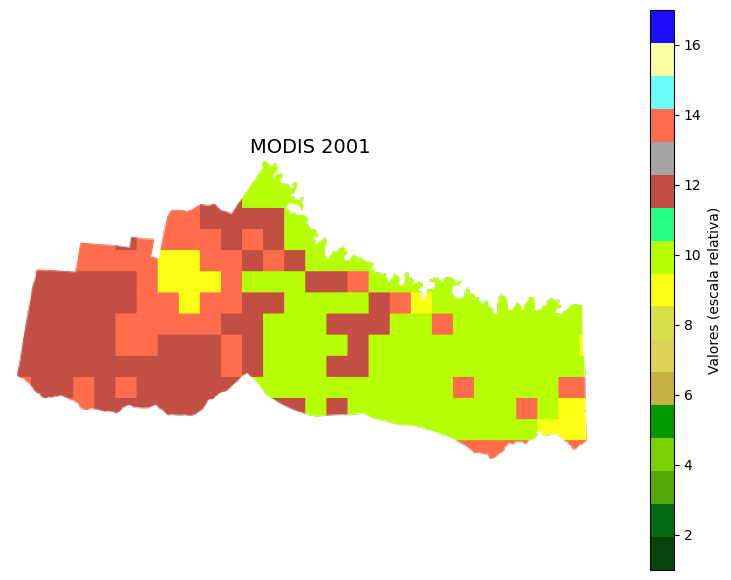

In [26]:
modis = ee.ImageCollection('MODIS/006/MCD12Q1') \
           .filterDate('2001-01-01', '2001-12-31') \
           .first() \
           .select('LC_Type1') \
           .clip(aoi)

modis_palette = [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159', 'dade48', 'fbff13',
    'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c', '69fff8', 'f9ffa4', '1c0dff'  
]

mostrar_imagen_ee(
    imagen=modis,
    region=aoi,
    titulo="MODIS 2001",
    min_val=1,
    max_val=17,
    palette=modis_palette
)

## 2.4. ESA WorldCover

**Cobertura de suelo global**

**Características**

| **Atributo**            | **Detalle**                                                      |
|-------------------------|------------------------------------------------------------------|
| Resolución Espacial     | 10 metros                                                       |
| Resolución Temporal     | Producto anual (versión 2020)                                   |
| Fuente                  | Agencia Espacial Europea (ESA)                                  |
| Esquema de Clasificación| 11 categorías globales de uso/cobertura de suelo                |
| Detección de Cambio     | Comparando diferentes versiones, permite estudios de cambio     |
| Cobertura Geográfica    | Global                                                          |

**Opciones de clasificación disponibles**

| **Código** | **Clase**           | **Color Hex** | **Descripción**                          |
|------------|---------------------|----------------|-------------------------------------------|
| 10         | Tree cover           | `#006400`      | Cobertura arbórea (bosques)              |
| 20         | Shrubland            | `#ffbb22`      | Matorrales                               |
| 30         | Grassland            | `#ffff4c`      | Pastizales                               |
| 40         | Cropland             | `#f096ff`      | Tierras agrícolas/cultivos               |
| 50         | Built-up             | `#fa0000`      | Áreas urbanas o construidas              |
| 60         | Bare / sparse vegetation | `#b4b4b4` | Zonas áridas o con vegetación dispersa   |
| 70         | Snow and ice         | `#f0f0f0`      | Nieve o hielo                            |
| 80         | Water bodies         | `#0032c8`      | Cuerpos de agua                          |
| 90         | Wetlands             | `#0096a0`      | Humedales                                |
| 95         | Mangroves            | `#00cf75`      | Manglares                                |
| 100        | Moss and lichen      | `#fae6a0`      | Musgos y líquenes                        |

**Nota**: Los códigos de clase en WorldCover van de 10 a 100, y cada valor representa un tipo de cobertura bien definido. 

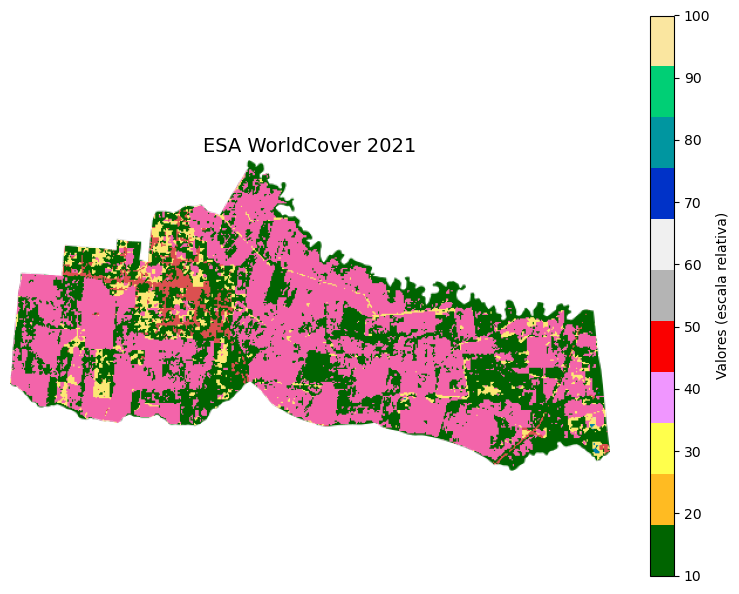

In [42]:
#v100 → Solo datos de 2020
#v200 → Datos de 2021
wCov = ee.ImageCollection('ESA/WorldCover/v200').first()
landcover20 = wCov.clip(aoi)

wc_palette = [
    '006400','ffbb22','ffff4c','f096ff','fa0000','b4b4b4','f0f0f0','0032c8','0096a0','00cf75','fae6a0'
]

mostrar_imagen_ee(
    imagen=landcover20,
    region=aoi,
    titulo="ESA WorldCover 2021",
    min_val=10,
    max_val=100,
    palette=wc_palette
)

## PASO 3: Compilación de la serie temporal de la cobertura vegetal

| Función                                        | Descripción                                |
|------------------------------------------------|--------------------------------------------|
| `ee.Date.fromYMD(year, month, day)`           | Crea una fecha.                           |
| `start.advance(amount, unit)`                 | Desplaza la fecha.                        |
| `.filterDate(start, end)`                     | Filtra por rango de fechas.               |
| `.filterBounds(geometry)`                     | Filtra por área geográfica.               |
| `.sum()`                                      | Suma imágenes, píxel a píxel.             |
| `.rename('new_band_name')`                    | Renombra banda.                           |
| `.clip(geometry)`                             | Recorta a un área.                        |
| `.set(properties)`                            | Añade metadatos.                          |
| `ee.Image().set({...})`                       | Imagen vacía con metadatos.               |
| `ee.Algorithms.If(cond, true_case, false_case)` | Condicional según la condición.           |

**Resumen:** Definir fechas, filtrar datos, procesar por área y año, añadir metadatos y usar condicionales.

 ### 3.1. Precipitación anual (CHIRPS Daily)

## **CHIRPS - Climate Hazards Group InfraRed Precipitation with Station Data**

**Resumen:**
- **Cobertura:** Cuasi-global (50°N a 50°S)
- **Resolución espacial:** 0.05° (~5 km)
- **Resolución temporal:** Diario, 10 días, Mensual
- **Período:** 1981 - Actualidad
- **Fuente:** Satélite + Estaciones meteorológicas
- **Acceso en Earth Engine:** `UCSB-CHG/CHIRPS/DAILY`

**Limitaciones:**
Menor precisión en zonas con pocas estaciones  
No cubre latitudes mayores a 50°  

**Otras**

| Producto       | Resolución | Período | Notas |
|----------------|------------|---------|-------|
| **GPM IMERG** | 0.1°, 30 min | 2000 - Actualidad | Alta resolución temporal, global 60°N-60°S |
| **PERSIANN-CDR** | 0.25°, Diario | 1983 - Actualidad | Series largas para estudios climáticos |
| **MSWEP** | 0.1°, Diario | 1979 - Actualidad | Combina estaciones, satélite y reanálisis |
| **ERA5 Reanalysis** | ~30 km, Horario | 1950 - Actualidad | Completo, incluye múltiples variables climáticas |

**¿Qué elegir?**

- **CHIRPS:** Estudios de sequía, agricultura, zonas tropicales  
- **GPM IMERG:** Eventos extremos, tormentas  
- **MSWEP / ERA5:** Modelado climático e hidrológico de largo plazo  



In [31]:
# Función para precipitación anual (CHIRPS)
def annual_precip(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')

    precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
        .filterDate(start, end) \
        .filterBounds(aoi) \
        .select('precipitation')

    count = precip.size()

    def _process(_):
        return precip.sum() \
            .rename('precip') \
            .clip(aoi) \
            .set({'year': year, 'system:time_start': start.millis()})

    def _empty(_):
        return ee.Image().set({'year': year, 'empty': True})

    return ee.Image(ee.Algorithms.If(count.gt(0), _process(None), _empty(None)))

### 3.2. NDVI máximo anual (MODIS MOD13Q1)

In [39]:
# Función para NDVI máximo anual
def annual_max_ndvi(year):
    start = ee.Date.fromYMD(year, 1, 1)
    end = start.advance(1, 'year')

    ndvi_coll = ee.ImageCollection('MODIS/006/MOD13Q1') \
        .filterDate(start, end) \
        .filterBounds(aoi) \
        .select('NDVI')

    count = ndvi_coll.size()

    def _process(_):
        return ndvi_coll.max() \
            .multiply(0.0001) \
            .rename('greenness') \
            .clip(aoi) \
            .set({'year': year, 'system:time_start': start.millis()})

    def _empty(_):
        return ee.Image().set({'year': year, 'empty': True})

    return ee.Image(ee.Algorithms.If(count.gt(0), _process(None), _empty(None)))

| Función                                          | Descripción breve                         |
|--------------------------------------------------|--------------------------------------------|
| `ee.Image(ndvi_img)`                            | Asegura que sea imagen de Earth Engine.   |
| `.addBands(precip_img)`                         | Combina NDVI y precipitación en multibanda. |
| `.set('year', year)`                            | Añade metadato de año.                    |
| `.set('system:time_start', ndvi_img.get(...))`  | Asigna fecha desde NDVI.                  |

**`system:time_start`**: Fecha en milisegundos (Unix Epoch), usada para ordenar, filtrar y analizar series temporales.

In [43]:
# Combina NDVI y precipitación por año
def combinar_ndvi_precip(year):
    ndvi_img = annual_max_ndvi(year)
    precip_img = annual_precip(year)

    # Verificar si ambas imágenes no están vacías
    return ee.Image(ndvi_img).addBands(precip_img) \
        .set('year', year) \
        .set('system:time_start', ndvi_img.get('system:time_start'))

### 3.3. Crear combined_collection

In [155]:
# Obtener la proyección del raster MODIS
ref_proj = modis.projection()
print(ref_proj.getInfo())

{'type': 'Projection', 'crs': 'SR-ORG:6974', 'transform': [463.312716528, 0, -20015109.354, 0, -463.312716527, 10007554.677]}


In [156]:
# Reproyectar cada imagen usando la proyección del raster
combined_collection_repro = combined_collection.map(
    lambda img: img.reproject(ref_proj)
)

In [157]:
years_present = combined_collection_repro.aggregate_array('year').getInfo()

print("Años disponibles en la colección:")
print(years_present)
print(f"\nAño mínimo disponible: {min(years_present)}")
print(f"Año máximo disponible: {max(years_present)}")

Años disponibles en la colección:
[2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

Año mínimo disponible: 2000
Año máximo disponible: 2023


### 3.4. Graficar NDVI vs. Precipitación

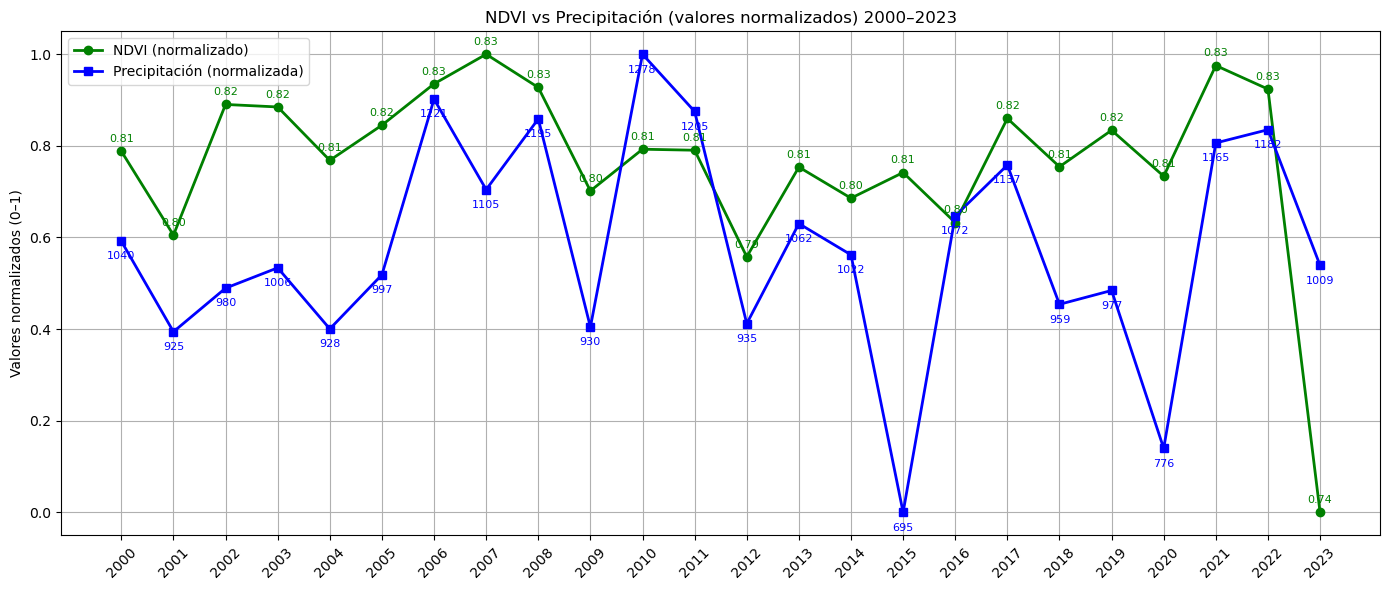

In [176]:
# Eliminar años con datos faltantes
df = df.dropna(subset=['NDVI_promedio', 'Precipitacion_mm'])

# Normalización min-max
df['NDVI_norm'] = (df['NDVI_promedio'] - df['NDVI_promedio'].min()) / (df['NDVI_promedio'].max() - df['NDVI_promedio'].min())
df['Precip_norm'] = (df['Precipitacion_mm'] - df['Precipitacion_mm'].min()) / (df['Precipitacion_mm'].max() - df['Precipitacion_mm'].min())

# Crear gráfico
fig, ax = plt.subplots(figsize=(14, 6))

# Graficar líneas normalizadas
ax.plot(df['Año'], df['NDVI_norm'], 'g-o', label='NDVI (normalizado)', linewidth=2)
ax.plot(df['Año'], df['Precip_norm'], 'b-s', label='Precipitación (normalizada)', linewidth=2)

# Etiquetas en puntos
for i in range(len(df)):
    ax.text(df['Año'].iloc[i], df['NDVI_norm'].iloc[i] + 0.02, f"{df['NDVI_promedio'].iloc[i]:.2f}", color='green', ha='center', fontsize=8)
    ax.text(df['Año'].iloc[i], df['Precip_norm'].iloc[i] - 0.04, f"{int(df['Precipitacion_mm'].iloc[i])}", color='blue', ha='center', fontsize=8)

# Personalización
ax.set_ylabel("Valores normalizados (0–1)")
ax.set_title("NDVI vs Precipitación (valores normalizados) 2000–2023")
ax.set_xticks(df['Año'])
ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
plt.xticks(rotation=45)
plt.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


,Año,NDVI_promedio,Precipitacion_mm,NDVI_predicho,Residuo
0,2000,0.812471,1040.297905,0.810677,0.001794
1,2001,0.795524,925.071270,0.805768,-0.010244
2,2002,0.821916,980.538037,0.808131,0.013785
3,2003,0.821411,1006.394789,0.809232,0.012179
4,2004,0.810630,928.702289,0.805922,0.004707
5,2005,0.817732,997.556050,0.808856,0.008876
6,2006,0.826081,1221.013476,0.818377,0.007705
7,2007,0.832062,1105.917933,0.813473,0.018589
8,2008,0.825350,1195.824719,0.817303,0.008046
9,2009,0.804459,930.980443,0.806019,-0.001560


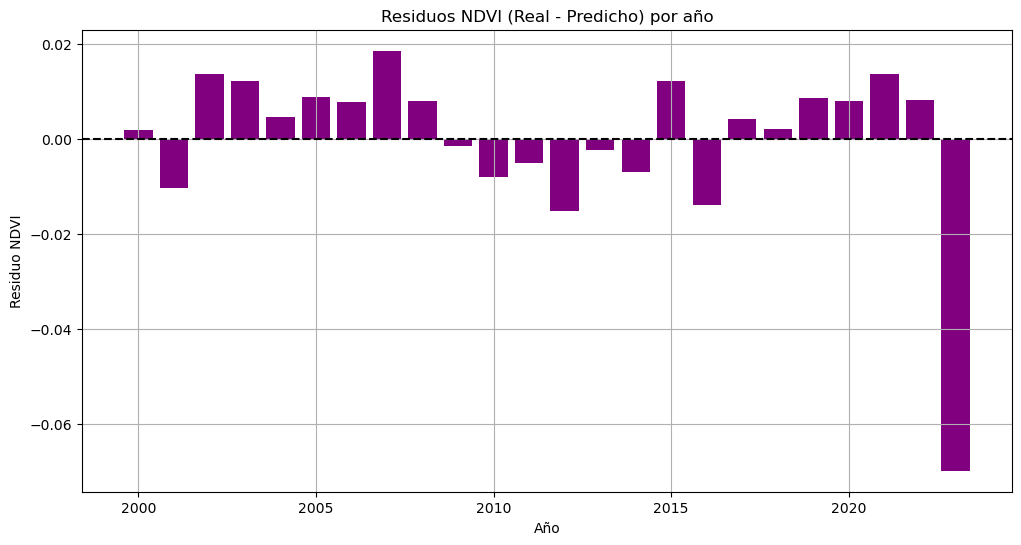

In [139]:
# Variables independientes y dependientes
x = df_clean['Precipitacion_mm'].values
y = df_clean['NDVI_promedio'].values

# Ajuste de regresión lineal NDVI = a * precip + b
coef = np.polyfit(x, y, 1)  # coef[0] = pendiente, coef[1] = intercepto

# Predicción de NDVI basado en precipitación
df_clean['NDVI_predicho'] = coef[0] * x + coef[1]

# Cálculo de residuos (real - predicho)
df_clean['Residuo'] = df_clean['NDVI_promedio'] - df_clean['NDVI_predicho']

# Mostrar resultados
display(df_clean[['Año', 'NDVI_promedio', 'Precipitacion_mm', 'NDVI_predicho', 'Residuo']])

# Visualización de residuos
plt.figure(figsize=(12, 6))
plt.bar(df_clean['Año'], df_clean['Residuo'], color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuos NDVI (Real - Predicho) por año')
plt.xlabel('Año')
plt.ylabel('Residuo NDVI')
plt.grid(True)
plt.show()


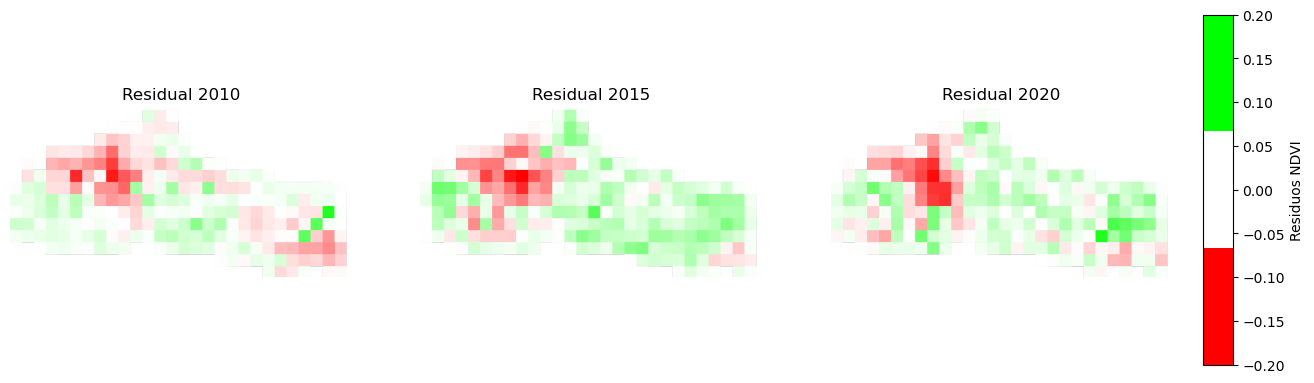

In [177]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, year in enumerate([2010, 2015, 2020]):
    imagen_anio = combined_collection_repro.filter(ee.Filter.eq('year', year)).first()
    ndvi_predicho = imagen_anio.select('precip').multiply(pendiente).add(intercepto)
    residual_img = imagen_anio.select('greenness').subtract(ndvi_predicho).rename('residual')

    mostrar_imagen_ee(
        imagen=residual_img,
        region=aoi,
        titulo=f"Residual {year}",
        min_val=-0.2,
        max_val=0.2,
        palette=["ff0000", "ffffff", "00ff00"],
        ax=axes[i],
        barra_color=False  # Evita que genere barra en cada subplot
    )

# Barra de color común
cmap = mcolors.ListedColormap(["#ff0000", "#ffffff", "#00ff00"])
norm = mcolors.Normalize(vmin=-0.2, vmax=0.2)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ColorbarBase(ax=cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cbar_ax.set_ylabel('Residuos NDVI', fontsize=10)

plt.show()


## PASO 4: Segmentación de series de tiempo

## 4.1. Define los parámetros de LandTrendr

In [181]:
run_params = {
    'maxSegments': 6,
    'spikeThreshold': 0.9,
    'vertexCountOvershoot': 3,
    'preventOneYearRecovery': True,
    'recoveryThreshold': 0.25,
    'pvalThreshold': 0.05,
    'bestModelProportion': 0.75,
    'minObservationsNeeded': 10,
    'timeSeries': combined_collection_repro
}

# Ejecuta LandTrendr
lt = ee.Algorithms.TemporalSegmentation.LandTrendr(**run_params)

# Selecciona el resultado principal
lt_output = lt.select('LandTrendr')

# Explora la salida
print(lt_output.getInfo())

{'type': 'Image', 'bands': [{'id': 'LandTrendr', 'data_type': {'type': 'PixelType', 'precision': 'double', 'dimensions': 2}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


## 4.2. Seleccionar la banda LandTrendr

## 4.3. Visualización

In [189]:
# Extraemos cantidad de años
num_bandas = dim_info['LandTrendr'][1]  # Eje 1 = años

# Ajusta según tu primer año de serie real
anio_inicio = 2000
years_list = [str(anio_inicio + i) for i in range(num_bandas)]

print("Años disponibles:", years_list)


Años disponibles: ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


In [190]:
# Aplanar el array con los años correctos
fitted_stack = fitted.arrayFlatten([['fittedResidual'], years_list]).toFloat()

# Confirmar estructura
print(fitted_stack.getInfo())


{'type': 'Image', 'bands': [{'id': 'fittedResidual_2000', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'fittedResidual_2001', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'fittedResidual_2002', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'fittedResidual_2003', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'fittedResidual_2004', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'fittedResidual_2005', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}, {'id': 'fittedResidual_2006', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': '

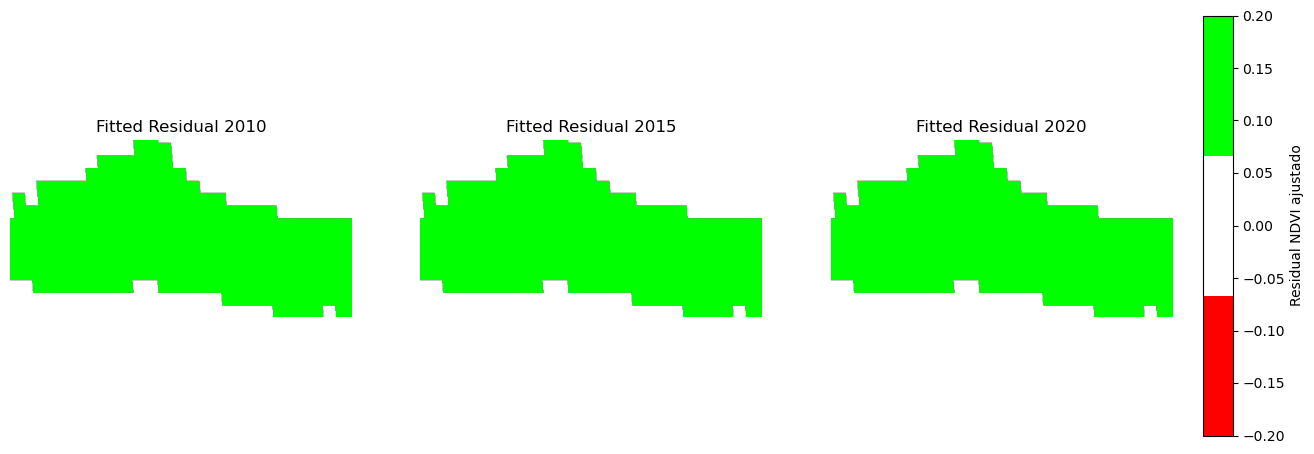

In [191]:
anios_mostrar = [2010, 2015, 2020]  # Solo los que estén presentes

fig, axes = plt.subplots(1, len(anios_mostrar), figsize=(5 * len(anios_mostrar), 6))

for i, year in enumerate(anios_mostrar):
    banda = f"fittedResidual_{year}"
    fitted_img = fitted_stack.select(banda)

    mostrar_imagen_ee(
        imagen=fitted_img,
        region=aoi,
        titulo=f"Fitted Residual {year}",
        min_val=-0.2,
        max_val=0.2,
        palette=["ff0000", "ffffff", "00ff00"],
        ax=axes[i],
        barra_color=False
    )

# Barra de color común
cmap = mcolors.ListedColormap(["#ff0000", "#ffffff", "#00ff00"])
norm = mcolors.Normalize(vmin=-0.2, vmax=0.2)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ColorbarBase(ax=cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cbar_ax.set_ylabel('Residual NDVI ajustado', fontsize=10)

plt.show()
